In [1]:
import pandas as pd
import numpy as np
from functions import *
from models import *
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

### Create simulated values

In [2]:
# load raw data
data = pd.read_csv('data/data.csv')

# financials[(financials['ticker'] == 'INVb.CO^F05')]
baspread = data[(data['ticker'] == 'NOVOb.CO')]['baspread'].values

In [3]:
np.random.seed(42)
beta = 2
datapoints = 100

# create simulations
x = baspread[-datapoints:]
# x_outofsample = baspread[100:200]


y = beta * x + np.random.normal(0, 0.0001, len(x))

y_train = y[:datapoints//2]
y_test = y[datapoints//2:]

# make x 2 dimensional
x = x.reshape(-1, 1)
x_train = x[:datapoints//2]
x_test = x[datapoints//2:]


### Run OLS

In [4]:
# estimate the parameters
b_hat = estimate(y_train,x_train)

for i in b_hat:
    print(i, b_hat[i])

ols_pred = b_hat['b_hat'][0]*x_test

b_hat [1.96790358]
se [[0.03040901]]
sigma2 9.030810185466768e-09
t_values [[64.71449438]]
R2 0.9297951802704164
cov [[0.00092471]]
wald [[4187.96578349]]
df 49


### Run LASSO (to be done)

### Run MLP

In [5]:
np.random.seed(42)
torch.manual_seed(42)

# create dataset objects for training and validation
train_dataset = MLPdataset(x_train[:9*(datapoints//20)], y_train[:9*(datapoints//20)])
val_dataset = MLPdataset(x_train[9*(datapoints//20):], y_train[9*(datapoints//20):])
# dataloaders for batching
train_loader = DataLoader(train_dataset, 
                        #   batch_size=64, 
                        #   shuffle=True
                          )
val_loader = DataLoader(val_dataset, 
                        # batch_size=64, 
                        # shuffle=False
                        )

# moving to metal or CUDA GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Using device:", device)

# hyperparameters
input_dim = x_train.shape[1]
model = MLPModel(input_dim).to(device)

# set regularization parameters
lambda_l1 = 0 # 1e-4
lambda_l2 = 0 # 1e-4

optimizer = optim.Adam(model.parameters(), lr=0.000001)
criterion = nn.MSELoss()

patience = 10
best_val_loss = float('inf')
best_model = None
epochs = 100

Using device: mps


In [6]:
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        # move data to GPU if available
        batch_X, batch_y = batch_X.to(device), batch_y.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # L1 and L2 regularization losses
        loss += l1_regularization(model, lambda_l1)
        loss += l2_regularization(model, lambda_l2)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)
    train_loss /= len(train_dataset)
    
    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device).unsqueeze(1)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            # Optionally, add reg losses to validation loss if you want to monitor them:
            loss += l1_regularization(model, lambda_l1)
            loss += l2_regularization(model, lambda_l2)
            val_loss += loss.item() * batch_X.size(0)
    val_loss /= len(val_dataset)

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.5f}, Validation Loss: {val_loss:.5f}")

    # early stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model = model
        torch.save(best_model.state_dict(), 'output/best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.5f}")
            break
    

Epoch 5/100 - Train Loss: 0.00452, Validation Loss: 0.00444
Epoch 10/100 - Train Loss: 0.00393, Validation Loss: 0.00385
Epoch 15/100 - Train Loss: 0.00339, Validation Loss: 0.00333
Epoch 20/100 - Train Loss: 0.00292, Validation Loss: 0.00286
Epoch 25/100 - Train Loss: 0.00249, Validation Loss: 0.00244
Epoch 30/100 - Train Loss: 0.00211, Validation Loss: 0.00206
Epoch 35/100 - Train Loss: 0.00178, Validation Loss: 0.00173
Epoch 40/100 - Train Loss: 0.00148, Validation Loss: 0.00144
Epoch 45/100 - Train Loss: 0.00122, Validation Loss: 0.00119
Epoch 50/100 - Train Loss: 0.00100, Validation Loss: 0.00097
Epoch 55/100 - Train Loss: 0.00080, Validation Loss: 0.00078
Epoch 60/100 - Train Loss: 0.00064, Validation Loss: 0.00062
Epoch 65/100 - Train Loss: 0.00051, Validation Loss: 0.00050
Epoch 70/100 - Train Loss: 0.00041, Validation Loss: 0.00039
Epoch 75/100 - Train Loss: 0.00032, Validation Loss: 0.00030
Epoch 80/100 - Train Loss: 0.00024, Validation Loss: 0.00023
Epoch 85/100 - Train Loss

In [7]:
test_dataset = MLPdataset(x_test, y_test)    # if you don’t have y_test, you can pass dummy zeros
test_loader = DataLoader(test_dataset, 
                        #  batch_size=64, 
                         shuffle=False
                         )

# 3) Run the model in eval mode and collect predictions
best_model.eval()
mlp_preds = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X) # shape: (batch_size, 1)
        
        # Move back to CPU and flatten
        preds = outputs.cpu().numpy().flatten()
        mlp_preds.extend(preds)

# convert to array
mlp_preds = np.array(mlp_preds)


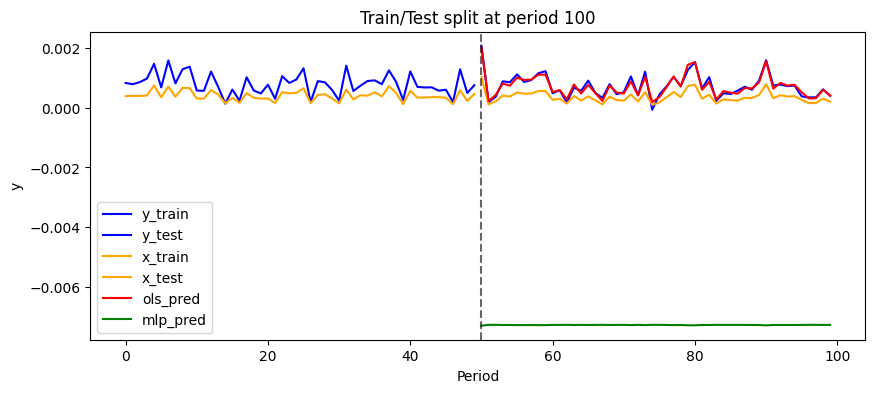

In [8]:
n_train = np.arange(len(y_train))
n_test  = np.arange(len(y_test), len(y_train) + len(y_test))

plt.figure(figsize=(10,4))
plt.plot(n_train, y_train, label='y_train', color='blue')
plt.plot(n_test,  y_test,  label='y_test', color='blue')

plt.plot(n_train, x_train, label='x_train', color='orange')
plt.plot(n_test,  x_test,  label='x_test', color='orange')

plt.plot(n_test, ols_pred, label='ols_pred', color='red')
plt.plot(n_test, mlp_preds, label='mlp_pred', color='green')

plt.axvline(len(y_train), color='k', linestyle='--', alpha=0.6)

plt.legend()
plt.xlabel("Period")
plt.ylabel("y")
plt.title("Train/Test split at period 100")
plt.show()